In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from utils.df_loader import (
    load_adult_df,
    load_compas_df,
    load_german_df,
    load_diabetes_df,
    load_breast_cancer_df,
)
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocess_df
from utils.models import (
    train_three_models,
    evaluation_test,
    save_three_models,
    load_three_models,
)
import utils.cf_proto as util_cf_proto
import utils.dice as util_dice
import utils.gs as util_gs
import utils.watcher as util_watcher
import utils.print as print_f


from utils.save import save_result_as_csv

### Only for alibi, to generate the results from GS and DiCE, commenting this section. ####


seed = 123
# tf.random.set_seed(seed)
# np.random.seed(seed)


In [2]:
RUN_ALIBI = False # (1)True(2)False
TRAIN_MODEL = False # (1)True(2)False
num_instances = 20 # (1)&(2) 20
num_cf_per_instance = 1 # (1)&(2)5

In [3]:
#to ensure the consistency all the experiments was ran on single 3 1070 3090 GPU  M1 GPU. .... OS. 

# github (tf, alibi).
if RUN_ALIBI:
    tf.get_logger().setLevel(40)
    tf.compat.v1.disable_v2_behavior()
    tf.keras.backend.clear_session()
    tf.compat.v1.disable_eager_execution()
    #############################################

    pd.options.mode.chained_assignment = None

    print("TF version: ", tf.__version__)
    print("Eager execution enabled: ", tf.executing_eagerly())  # False    

In [5]:
print("TF version: ", tf.__version__)
print("Eager execution enabled: ", tf.executing_eagerly())  # False    

TF version:  2.0.0
Eager execution enabled:  True


In [6]:
import tensorflow as tf
print(tf.__version__)

2.0.0


Dataset Name: [diabetes]


2022-08-24 16:41:46.914826: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 16:41:46.915291: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: [Decision Tree] | Accuracy: [0.7857] | Precision: [0.6923 | Recall: [0.7759] | F1: [0.7317]


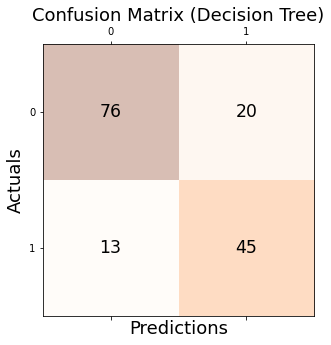

Model: [Random Forest] | Accuracy: [0.7857] | Precision: [0.7358 | Recall: [0.6724] | F1: [0.7027]


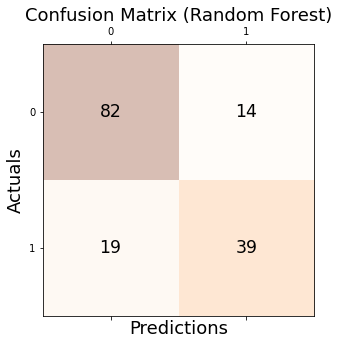

Model: [Neural Network] | Accuracy: [0.7273] | Precision: [0.6429 | Recall: [0.6207] | F1: [0.6316]


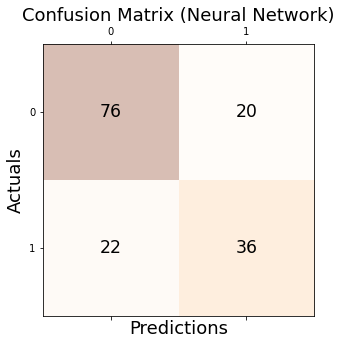


====================Counterfactual Algorithm====================
| GS 
Finding counterfactual for dt
instance 0
CF 0
In the setup
606 ennemies found in initial sphere. Zooming in...
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  11
Final radius:  (0.019, 0.0208)
Final number of ennemies:  3
Feature selection...
Type out is
object
Type self.obs_to_interprete is
object
Reduced 7 coordinates
instance 1
CF 0
In the setup
1155 ennemies found in initial sphere. Zooming in...
2 ennemies found in initial sphere. Zooming in...
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  51
Final radius:  (0.00909999999999999, 0.00927999999999999)
Final number of ennemies:  1
Feature selection...
Type out is
object
Type self.obs_to_interprete is
object
Reduced 7 coordinates
instance 2
CF 0
In the setup
520 ennemies found in initial sphere. Zooming in...
0 ennemies found in initial sphere. Zooming in...
Exploring...
Fina

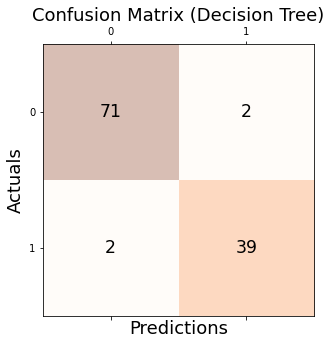

Model: [Random Forest] | Accuracy: [0.9912] | Precision: [1.0000 | Recall: [0.9756] | F1: [0.9877]


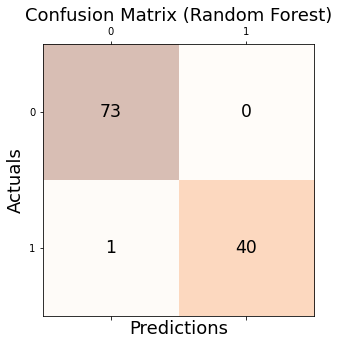

Model: [Neural Network] | Accuracy: [0.9737] | Precision: [0.9750 | Recall: [0.9512] | F1: [0.9630]


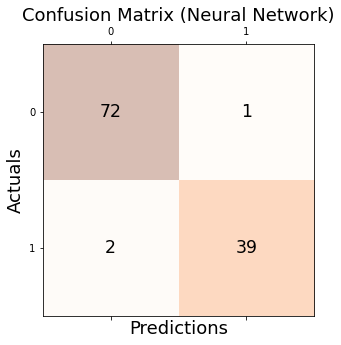


====================Counterfactual Algorithm====================
| GS 
Finding counterfactual for dt
instance 0
CF 0
In the setup
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  17
Final radius:  (0.298, 0.316)
Final number of ennemies:  1
Feature selection...
Type out is
object
Type self.obs_to_interprete is
object
Reduced 28 coordinates
instance 1
CF 0
In the setup
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  20
Final radius:  (0.35200000000000004, 0.37000000000000005)
Final number of ennemies:  1
Feature selection...
Type out is
object
Type self.obs_to_interprete is
object
Reduced 29 coordinates
instance 2
CF 0
In the setup
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  6
Final radius:  (0.1, 0.11800000000000001)
Final number of ennemies:  1
Feature selection...
Type out is
object
Type self.obs_to_interprete is
object
Reduced 29 coordinates
instanc

In [7]:
#### Select dataset ####
for dataset_name in [
    "adult",
    "german",
     "compas",
    "diabetes",
    "breast_cancer",
]:  # [adult, german, compas]
    print(f"Dataset Name: [{dataset_name}]")
    if dataset_name == "adult":
        dataset_loading_fn = load_adult_df
    elif dataset_name == "german":
        dataset_loading_fn = load_german_df
    elif dataset_name == "compas":
        dataset_loading_fn = load_compas_df
    elif dataset_name == "diabetes":
        dataset_loading_fn = load_diabetes_df
    elif dataset_name == "breast_cancer":
        dataset_loading_fn = load_breast_cancer_df
    else:
        raise Exception("Unsupported dataset")

    df_info = preprocess_df(dataset_loading_fn)

    train_df, test_df = train_test_split(
        df_info.dummy_df, train_size=0.8, random_state=seed, shuffle=True
    )
    X_train = np.array(train_df[df_info.ohe_feature_names])
    y_train = np.array(train_df[df_info.target_name])
    X_test = np.array(test_df[df_info.ohe_feature_names])
    y_test = np.array(test_df[df_info.target_name])

    if TRAIN_MODEL:
        ## Train models.
        models = train_three_models(X_train, y_train)
        ## Save models.
        save_three_models(models, dataset_name)

    ### Load models
    models = load_three_models(X_train.shape[-1], dataset_name)

    ### Print out accuracy on testset.
    evaluation_test(models, X_test, y_test)

    if dataset_name in ["diabetes", "breast_cancer"]:
        # run the cf algorithms supporting categorical data.

        # watcher and gs can only run for the datasets containing numerical data only.
        if RUN_ALIBI:
            print_f.print_block(title="Counterfactual Algorithm", content="Watcher")
            results = util_watcher.generate_watcher_result(
                df_info,
                train_df,
                models,
                num_instances,
                num_cf_per_instance,
                X_train,
                X_test,
                y_test,
                max_iters=1000,
                models_to_run=["dt", "rfc", "nn"],
                output_int=True,
            )
            result_dfs = util_watcher.process_result(results, df_info)
            save_result_as_csv("watcher", dataset_name, result_dfs)

        # else:
        print_f.print_block(title="Counterfactual Algorithm", content="GS")
        results, instance_cfs = util_gs.generate_gs_result(
            df_info, test_df, models, num_instances, num_cf_per_instance, 2000
        )
        result_dfs = util_gs.process_results(df_info, results)
        save_result_as_csv("GS", dataset_name, result_dfs)

    if RUN_ALIBI:
        print_f.print_block(title="Counterfactual Algorithm", content="Prototype")
        results = util_cf_proto.generate_cf_proto_result(
            df_info,
            train_df,
            models,
            num_instances,
            num_cf_per_instance,
            X_train,
            X_test,
            y_test,
            max_iters=1000,
            models_to_run=["dt", "rfc", "nn"],
            output_int=True,
        )
        result_dfs = util_cf_proto.process_result(results, df_info)
        save_result_as_csv("proto", dataset_name, result_dfs)

    else:
        print_f.print_block(title="Counterfactual Algorithm", content="DiCE")
        results = util_dice.generate_dice_result(
            df_info,
            test_df,
            models,
            num_instances,
            num_cf_per_instance,
            sample_size=50,
            models_to_run=["dt", "rfc", "nn"],
        )
        result_dfs = util_dice.process_results(df_info, results)
        save_result_as_csv("dice", dataset_name, result_dfs)
